Using device: cuda
Loading model from c:\Users\yingq\Desktop\SRGAN\SRGAN-Implementation\models\srresnet_mse.pth...
Loading model from c:\Users\yingq\Desktop\SRGAN\SRGAN-Implementation\models\checkpoint_epoch_195.pth...
Generator loaded successfully.
Loading model from c:\Users\yingq\Desktop\SRGAN\SRGAN-Implementation\models\best_model_without_pixel_lowlr.pth...
Generator loaded successfully.
Loading model from c:\Users\yingq\Desktop\SRGAN\SRGAN-Implementation\models\best_model_with_pixel_0.pth...
Generator loaded successfully.
Original HR image size: (250, 361)
LR image size: (62, 90)
LR tensor shape for model: torch.Size([1, 3, 90, 62])


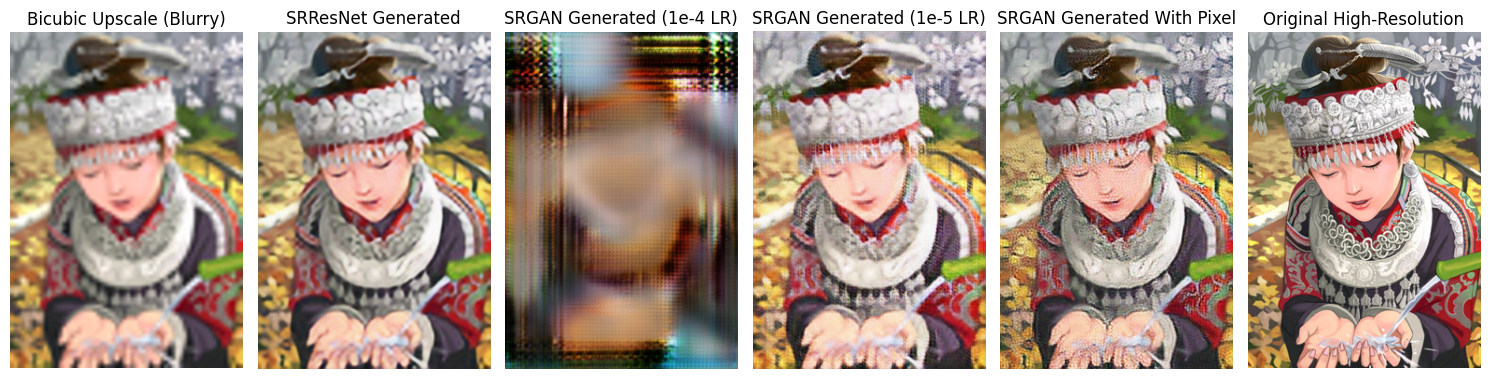

In [6]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path

current_dir = Path(os.getcwd())
if current_dir.name == 'model_components':
    parent_dir = str(current_dir.parent)
else:
    parent_dir = str(current_dir)

if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from model_components.generator import Generator

MODEL_PATH = current_dir.parent / "models" / "srresnet_mse.pth"
IMAGE_PATH = current_dir.parent / "comic.png"
UPSCALE_FACTOR = 4

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the generator
generator = Generator().to(device)

# Load weights
print(f"Loading model from {MODEL_PATH}...")
checkpoint = torch.load(MODEL_PATH, map_location=device)
if 'generator_state_dict' in checkpoint:
    generator.load_state_dict(checkpoint['generator_state_dict'])
    print("Generator loaded successfully.")
else:
    generator.load_state_dict(checkpoint) 

generator.eval()

GAN_NO_PIXEL_MODEL_PATH = current_dir.parent / "models" / "checkpoint_epoch_195.pth"

# Initialize the generator
srgan_no_pixel_generator = Generator().to(device)

# Load weights
print(f"Loading model from {GAN_NO_PIXEL_MODEL_PATH}...")
checkpoint = torch.load(GAN_NO_PIXEL_MODEL_PATH, map_location=device)

srgan_no_pixel_generator.load_state_dict(checkpoint['generator_state_dict'])
print("Generator loaded successfully.")

GAN_NO_PIXEL_MODEL_PATH_BETTER = current_dir.parent / "models" / "best_model_without_pixel_lowlr.pth"

# Initialize the generator
srgan_no_pixel_generator_better = Generator().to(device)

# Load weights
print(f"Loading model from {GAN_NO_PIXEL_MODEL_PATH_BETTER}...")
checkpoint = torch.load(GAN_NO_PIXEL_MODEL_PATH_BETTER, map_location=device)

srgan_no_pixel_generator_better.load_state_dict(checkpoint['generator_state_dict'])
print("Generator loaded successfully.")


GAN_MODEL_PATH = current_dir.parent / "models" / "best_model_with_pixel_0.pth"

# Initialize the generator
srgan_generator = Generator().to(device)

# Load weights
print(f"Loading model from {GAN_MODEL_PATH}...")
checkpoint = torch.load(GAN_MODEL_PATH, map_location=device)

srgan_generator.load_state_dict(checkpoint['generator_state_dict'])
print("Generator loaded successfully.")


srgan_generator.eval()

# Load the High-Resolution  image
hr_image_pil = Image.open(IMAGE_PATH).convert("RGB")

# We use bicubic downsampling, as done in the paper's data pipeline
w, h = hr_image_pil.size
lr_w, lr_h = w // UPSCALE_FACTOR, h // UPSCALE_FACTOR
lr_image_pil = hr_image_pil.resize((lr_w, lr_h), Image.BICUBIC)

bicubic_image_pil = lr_image_pil.resize((w, h), Image.BICUBIC)

lr_transform = transforms.ToTensor()
lr_tensor = lr_transform(lr_image_pil).unsqueeze(0).to(device)

print(f"Original HR image size: {hr_image_pil.size}")
print(f"LR image size: {lr_image_pil.size}")
print(f"LR tensor shape for model: {lr_tensor.shape}")


def display_image(tensor, title=""):
    img = tensor.cpu().permute(1, 2, 0)
    img = torch.clamp(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

with torch.no_grad():
    sr_tensor_tanh = generator(lr_tensor)
    sr_tensor_tanh_gan = srgan_generator(lr_tensor)
    sr_tensor_tanh_gan_no_pixel = srgan_no_pixel_generator(lr_tensor)
    sr_tensor_gan_no_pixel_better = srgan_no_pixel_generator_better(lr_tensor)


sr_tensor = (sr_tensor_tanh + 1.0) / 2.0
sr_tensor_gan = (sr_tensor_tanh_gan + 1.0) / 2.0
sr_tensor_gan_no_pixel = (sr_tensor_tanh_gan_no_pixel + 1.0) / 2.0
sr_tensor_gan_no_pixel_better = (sr_tensor_gan_no_pixel_better + 1.0) / 2.0

sr_tensor = sr_tensor.squeeze(0)
sr_tensor_gan = sr_tensor_gan.squeeze(0)
sr_tensor_gan_no_pixel = sr_tensor_gan_no_pixel.squeeze(0)
sr_tensor_gan_no_pixel_better = sr_tensor_gan_no_pixel_better.squeeze(0)

bicubic_tensor = transforms.ToTensor()(bicubic_image_pil)
hr_tensor = transforms.ToTensor()(hr_image_pil)

plt.figure(figsize=(15, 5))

# Plot 1: Bicubic
plt.subplot(1, 6, 1)
display_image(bicubic_tensor, title=f"Bicubic Upscale (Blurry)")

plt.subplot(1, 6, 2)
display_image(sr_tensor, title=f"SRResNet Generated")


plt.subplot(1, 6, 3)
display_image(sr_tensor_gan_no_pixel, title=f"SRGAN Generated (1e-4 LR)")

plt.subplot(1, 6, 4)
display_image(sr_tensor_gan_no_pixel_better, title=f"SRGAN Generated (1e-5 LR)")

plt.subplot(1, 6, 5)
display_image(sr_tensor_gan, title=f"SRGAN Generated With Pixel")

plt.subplot(1, 6, 6)
display_image(hr_tensor, title="Original High-Resolution")

plt.tight_layout()
plt.show()
